In [80]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import numpy as np
import pandas as pd

from PIL import Image

In [81]:
station_1 = pd.read_csv('csvs/dn_20210111_gcl.csv').sort_values(['label', 'count'], ascending=[False, False])
station_2 = pd.read_csv('csvs/dn_20210114_gcl.csv').sort_values(['label', 'count'], ascending=[False, False])
station_3 = pd.read_csv('csvs/dn_20210122_gcl.csv').sort_values(['label', 'count'], ascending=[False, False])
station_4 = pd.read_csv('csvs/hsn_20201227_gcl.csv').sort_values(['label', 'count'], ascending=[False, False])
station_5 = pd.read_csv('csvs/hsn_20210120_4k_gcl.csv').sort_values(['label', 'count'], ascending=[False, False])

<font size="3">List the top 3 of each station with the format in a list S[station number]</font>

In [82]:
S1 = ["Cyanobacteria", "Neoceratium pentagonum", "Steenstrupiella"]
S2 = ["Neoceratium pentagonum", "Chaetoceros", "Rhabdonella"]
S3 = ["Cyanobacteria", "Diatoma", "Eucampia"]
S4 = ["Neoceratium fusus", "Copepoda", "Chaetoceros"]
S5 = ["Diatoma", "Cyanobacteria", "Hemiaulus"]

In [83]:
def get_station_counts(first, second, third, station):
    """Takes in the three highest occurence of plankton and the station it was at.
    Generates the counts of each of those plankton, and stats of Plankton, Detritus, Others, and Total.
    Returns counts of rank 1, 2, 3, sum of plankton, sum of detritus, sum of others, and sum of all things in a tuple """

    count_1 = int(station[station['genus'] == first]['count'])
    count_2 = int(station[station['genus'] == second]['count'])
    count_3 = int(station[station['genus'] == third]['count'])

    planktonsumcounts = sum(station[station['label'] == 1]['count'])
    detrituscounts = int(station[station['genus'] == 'detritus']['count'])
    sumcounts = sum(station['count'].to_list())
    otherscounts = sumcounts - detrituscounts - planktonsumcounts

    return (count_1, count_2, count_3, planktonsumcounts, detrituscounts, otherscounts, sumcounts)

In [84]:
S1_stats = get_station_counts(S1[0], S1[1], S1[2], station_1)
S2_stats = get_station_counts(S2[0], S2[1], S2[2], station_2)
S3_stats = get_station_counts(S3[0], S3[1], S3[2], station_3)
S4_stats = get_station_counts(S4[0], S4[1], S4[2], station_4)
S5_stats = get_station_counts(S5[0], S5[1], S5[2], station_5)

In [85]:
offset = 250
padding = 4
cmap = mcolors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])
gspolarpie = GridSpec(nrows=1, ncols=2)
gsimg = GridSpec(nrows=7, ncols=5)
pie_labels = ["Plankton", "Detritus", "Others"]

In [91]:
def show_images(IGC1, IGC2, IGC3, stationstats, stationname, fig):

    im1 = Image.open(f'imagesforgraph/{IGC1}.jpg').resize((224, 224), resample=Image.NEAREST)
    im2 = Image.open(f'imagesforgraph/{IGC2}.jpg').resize((224, 224), resample=Image.NEAREST)
    im3 = Image.open(f'imagesforgraph/{IGC3}.jpg').resize((224, 224), resample=Image.NEAREST)

    newax = fig.add_subplot(gsimg[1:2, 2])
    newax.imshow(im1)
    newax.set_title(f"{IGC1}\n {stationstats[0]} counts ({round(stationstats[0]/stationstats[6] * 100, 2)}%)", fontsize=10)
    newax.axis('off')

    newax2 = fig.add_subplot(gsimg[3:4, 2])
    newax2.imshow(im2)
    newax2.set_title(f"{IGC2}\n {stationstats[1]} counts ({round(stationstats[0]/stationstats[6] * 100, 2)}%)", fontsize=10)
    newax2.axis('off')

    newax3 = fig.add_subplot(gsimg[5:6, 2])
    newax3.imshow(im3)
    newax3.set_title(f"{IGC3}\n {stationstats[2]} counts ({round(stationstats[0]/stationstats[6] * 100, 2)}%)", fontsize=10)
    newax3.axis('off')

    plt.savefig(f'graphs/{stationname}.jpg', bbox_inches='tight')
    plt.show()
    plt.clf()

<font size="3">Plotting the polar + pie graph</font>

In [93]:
def plot_station_graph(s_stats, station, stationname, ranks):

    # Percentage of Plankton, Detritus, and Others (Sums up to 100%)
    pie_values = [s_stats[3]/s_stats[6], s_stats[4]/s_stats[6], s_stats[5]/s_stats[6]]

    # Settings for the polar graph
    fig = plt.figure(figsize=(25, 15), constrained_layout=True)
    ax = fig.add_subplot(gspolarpie[:, 0], polar=True)
    ax.axis('off')
    ax.set_title(f'{stationname} Sample Counts: {s_stats[6]}', va='bottom', fontsize=30, y=1.10, x=0.5)
    width = 2 * np.pi / len(station.index) 
    angles = np.arange(0, 2 * np.pi, width)
    bars = ax.bar(x=angles, height=np.log(station['count']) * 100, width=width, bottom=offset, linewidth=4, edgecolor='white', color=cmap(np.log(station['count']) / np.log(station['count']).max()))

    # Setting rotation of labels in polar graph
    for bar, angle, label in zip(bars, angles, station['genus']):
        rotation = -np.rad2deg(angle)
        if angle >= 0 and angle < np.pi:
            alignment = "left"
            rotation += 90
        else:
            alignment = "right"
            rotation += 270

        ax.text(x=angle, y=offset + bar.get_height() + padding, s=label, ha=alignment, va='center', rotation=rotation, rotation_mode='anchor')

    # Making sure labels are rotated correctlye
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    # Settings for the pie graph
    axp = fig.add_subplot(gspolarpie[:, 0], label='pie axes', zorder=0)
    axp.pie(pie_values, radius=0.29, autopct='%1.0f%%', startangle=90, labeldistance=0, counterclock=False, pctdistance=0.5, colors=['blue', 'lightsteelblue', 'dodgerblue'], textprops={'fontsize': 14})
    axp.legend(pie_labels, fontsize=13, loc='upper left')
    axp.set(aspect="equal")

    show_images(ranks[0], ranks[1], ranks[2], s_stats, stationname, fig)

    



<ipython-input-91-94cfc3748efa>:22: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(f'graphs/{stationname}.jpg', bbox_inches='tight')
c:\Users\gates\Desktop\project\venv\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


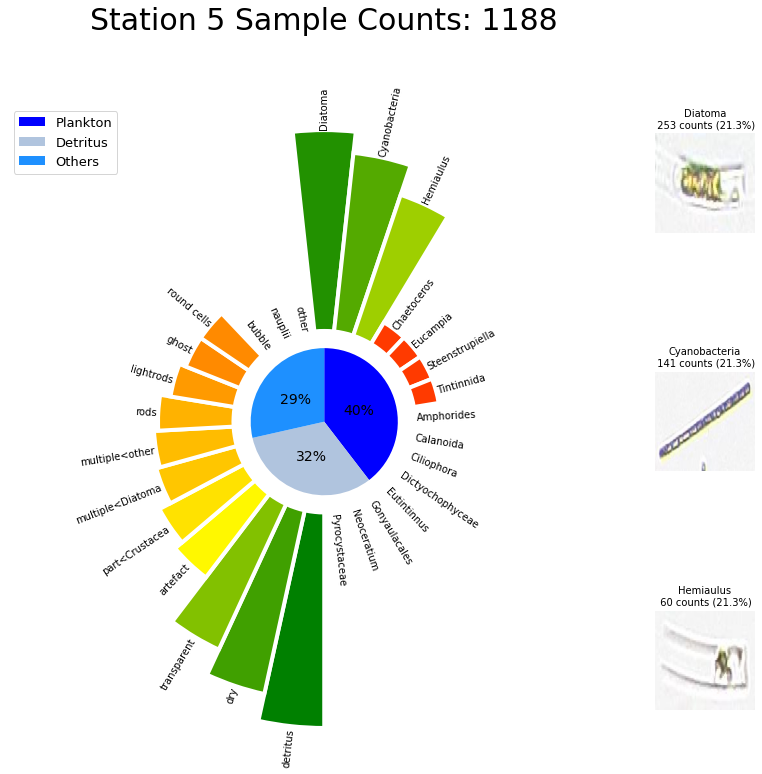

<Figure size 432x288 with 0 Axes>

In [98]:
plot_station_graph(S5_stats, station_5, "Station 5", S5)